In [1]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img

%load_ext autoreload
%autoreload 2

In [9]:
class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 40  # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep=5 #"the number of local epochs: E"
    local_bs=500 #"local batch size: B"
    bs=128 #"test batch size"
    lr=0.01 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='batch_norm' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")
    
    opt = 'ADAM'

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

In [10]:
args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
if args.dataset == 'mnist':
    trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
    dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)
    # sample users
    if args.iid:
        dict_users = mnist_iid(dataset_train, args.num_users)
    else:
        dict_users = mnist_noniid(dataset_train, args.num_users)
elif args.dataset == 'cifar':
    trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset_train = datasets.CIFAR10('../data/cifar', train=True, download=True, transform=trans_cifar)
    dataset_test = datasets.CIFAR10('../data/cifar', train=False, download=True, transform=trans_cifar)
    if args.iid:
        dict_users = cifar_iid(dataset_train, args.num_users)
    else:
        exit('Error: only consider IID setting in CIFAR10')
else:
    exit('Error: unrecognized dataset')
img_size = dataset_train[0][0].shape

In [11]:
use_cuda = torch.cuda.is_available()
print(use_cuda)
args.device = torch.device("cuda" if use_cuda else "cpu")
print(args.device)

True
cuda


# 1. FedAvg

In [12]:
# build model
if args.model == 'cnn' and args.dataset == 'cifar':
    net_glob = CNNCifar(args=args).to(args.device)
elif args.model == 'cnn' and args.dataset == 'mnist':
    net_glob = CNNMnist2(args=args).to(args.device)
elif args.model == 'mlp':
    len_in = 1
    for x in img_size:
        len_in *= x
    net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
else:
    exit('Error: unrecognized model')
print(net_glob)
net_glob.train()

# copy weights
w_glob = net_glob.state_dict()

# training
loss_train = []
loss_test_arr = []
acc_test_arr = []
cv_loss, cv_acc = [], []
val_loss_pre, counter = 0, 0
net_best = None
best_loss = None
val_acc_list, net_list = [], []

for iter in range(200): #args.epochs
    w_locals, loss_locals = [], []
    m = 13
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    for idx in idxs_users:
#         print(idx)
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
        w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))
    # update global weights
    w_glob = FedAvg(w_locals)

    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)

    # print loss
    loss_avg = sum(loss_locals) / len(loss_locals)
    
    loss_train.append(loss_avg)
    
    acc_test, loss_test = test_img(net_glob, dataset_test, args)
    acc_test_arr.append(acc_test)
    loss_test_arr.append(loss_test)
    if iter % 1 ==0:
        print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
    #print(loss_train)

CNNMnist2(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)

Test set: Average loss: 0.9540 
Accuracy: 8122/10000 (81.22%)

Round   0, Average loss 1.851 Test accuracy 81.220


KeyboardInterrupt: 

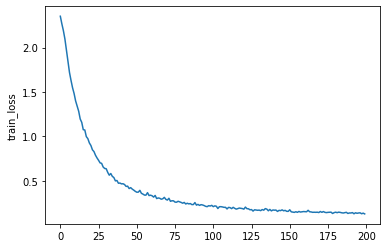

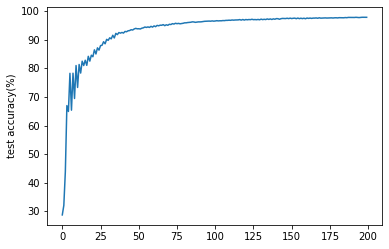

In [92]:
# plot loss curve
#print(loss_locals)
#print(loss_train)
# plt.figure()
plt.plot(range(len(loss_train)), loss_train)
plt.ylabel('train_loss')
plt.show()
# plt.savefig('./save/fed_{}_{}_{}_C{}_iid{}.png'.format(args.dataset, args.model, args.epochs, args.frac, args.iid))

loss_train_Fedavg = loss_train
acc_test_Fedavg = acc_test_arr

plt.plot(range(len(acc_test_Fedavg)), acc_test_Fedavg)
plt.ylabel('test accuracy(%)')
plt.show()
#print(loss_train_Fedavg)

In [93]:
# testing
net_glob.eval()
acc_train, loss_train = test_img(net_glob, dataset_train, args)
acc_test, loss_test = test_img(net_glob, dataset_test, args)
print("Training accuracy: {:.2f}".format(acc_train))
print("Testing accuracy: {:.2f}".format(acc_test))


Test set: Average loss: 0.0856 
Accuracy: 58573/60000 (97.62%)


Test set: Average loss: 0.0742 
Accuracy: 9782/10000 (97.82%)

Training accuracy: 97.62
Testing accuracy: 97.82


# 2. Quantized FedAvg

In [141]:
# build model
if args.model == 'cnn' and args.dataset == 'cifar':
    net_glob = CNNCifar(args=args).to(args.device)
elif args.model == 'cnn' and args.dataset == 'mnist':
    net_glob = CNNMnist2(args=args).to(args.device)
elif args.model == 'mlp':
    len_in = 1
    for x in img_size:
        len_in *= x
    net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
else:
    exit('Error: unrecognized model')
print(net_glob)
net_glob.train()

# copy weights
w_glob = net_glob.state_dict()

# training
loss_train = []
loss_test_arr = []
acc_test_arr = []
cv_loss, cv_acc = [], []
val_loss_pre, counter = 0, 0
net_best = None
best_loss = None
val_acc_list, net_list = [], []
q_bit = 256

for iter in range(200): #args.epochs
    w_locals, loss_locals = [], []
    m = 13
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    for idx in idxs_users:
#         print(idx)
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
        w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))
    # update global weights
    w_glob, w_tmp = FedQAvg(w_locals,q_bit)

    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)

    # print loss
    loss_avg = sum(loss_locals) / len(loss_locals)
    loss_train.append(loss_avg)
    #print(loss_train)
    
    acc_test, loss_test = test_img(net_glob, dataset_test, args)
    acc_test_arr.append(acc_test)
    loss_test_arr.append(loss_test)
    if iter % 1 ==0:
        print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))

CNNMnist2(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)

Test set: Average loss: 2.2674 
Accuracy: 2387/10000 (23.87%)

Round   0, Average loss 2.348 Test accuracy 23.870

Test set: Average loss: 2.2190 
Accuracy: 3618/10000 (36.18%)

Round   1, Average loss 2.276 Test accuracy 36.180

Test set: Average loss: 2.1923 
Accuracy: 3797/10000 (37.97%)

Round   2, Average loss 2.241 Test accuracy 37.970

Test set: Average loss: 2.1799 
Accuracy: 4088/10000 (40.88%)

Round   3, Average loss 2.227 Test accuracy 40.880

Test set: Average loss: 2.1754 
Accuracy: 4375/10000 (43.75%)

Round   4, Average loss 2.224 Test accuracy 43.750

Test set: Average loss: 2.1697 
Accuracy: 4345/10000 (43.45%)

Round   5, Average loss 2.220 Test accuracy 43.450

Test set: Average loss: 2.1709 
Accuracy: 4281/10000 (42.81%)

Ro


Test set: Average loss: 2.1644 
Accuracy: 4285/10000 (42.85%)

Round  70, Average loss 2.209 Test accuracy 42.850

Test set: Average loss: 2.1645 
Accuracy: 4352/10000 (43.52%)

Round  71, Average loss 2.208 Test accuracy 43.520

Test set: Average loss: 2.1634 
Accuracy: 4457/10000 (44.57%)

Round  72, Average loss 2.212 Test accuracy 44.570

Test set: Average loss: 2.1647 
Accuracy: 4328/10000 (43.28%)

Round  73, Average loss 2.207 Test accuracy 43.280

Test set: Average loss: 2.1633 
Accuracy: 4347/10000 (43.47%)

Round  74, Average loss 2.212 Test accuracy 43.470

Test set: Average loss: 2.1634 
Accuracy: 4372/10000 (43.72%)

Round  75, Average loss 2.209 Test accuracy 43.720

Test set: Average loss: 2.1639 
Accuracy: 4392/10000 (43.92%)

Round  76, Average loss 2.211 Test accuracy 43.920

Test set: Average loss: 2.1645 
Accuracy: 4391/10000 (43.91%)

Round  77, Average loss 2.212 Test accuracy 43.910

Test set: Average loss: 2.1648 
Accuracy: 4366/10000 (43.66%)

Round  78, Avera


Test set: Average loss: 2.1645 
Accuracy: 4227/10000 (42.27%)

Round 142, Average loss 2.213 Test accuracy 42.270

Test set: Average loss: 2.1640 
Accuracy: 4393/10000 (43.93%)

Round 143, Average loss 2.208 Test accuracy 43.930

Test set: Average loss: 2.1644 
Accuracy: 4428/10000 (44.28%)

Round 144, Average loss 2.211 Test accuracy 44.280

Test set: Average loss: 2.1640 
Accuracy: 4343/10000 (43.43%)

Round 145, Average loss 2.214 Test accuracy 43.430

Test set: Average loss: 2.1651 
Accuracy: 4224/10000 (42.24%)

Round 146, Average loss 2.210 Test accuracy 42.240

Test set: Average loss: 2.1635 
Accuracy: 4338/10000 (43.38%)

Round 147, Average loss 2.208 Test accuracy 43.380

Test set: Average loss: 2.1633 
Accuracy: 4314/10000 (43.14%)

Round 148, Average loss 2.212 Test accuracy 43.140

Test set: Average loss: 2.1629 
Accuracy: 4425/10000 (44.25%)

Round 149, Average loss 2.214 Test accuracy 44.250

Test set: Average loss: 2.1640 
Accuracy: 4355/10000 (43.55%)

Round 150, Avera

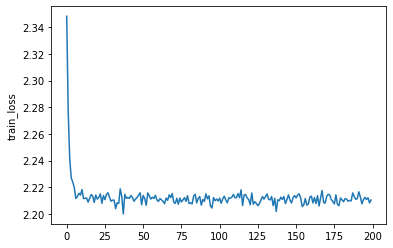

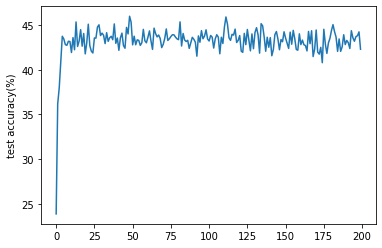

In [142]:
plt.plot(range(len(loss_train)), loss_train)
plt.ylabel('train_loss')
plt.show()
# plt.savefig('./save/fed_{}_{}_{}_C{}_iid{}.png'.format(args.dataset, args.model, args.epochs, args.frac, args.iid))

loss_train_Brea = np.array(loss_train)
acc_test_Brea = np.array(acc_test_arr)

plt.plot(range(len(acc_test_Brea)), acc_test_Brea)
plt.ylabel('test accuracy(%)')
plt.show()
#print(loss_train_Fedavg)

pickle.dump(acc_test_Brea, open('./results/Brea_Accuracy_N40_M13_A12_q'+str(q_bit), 'wb'), -1)
pickle.dump(loss_train_Brea, open('./results/Brea_Loss_N40_M13_A12_q'+str(q_bit), 'wb'), -1)

In [101]:
import pickle as pickle
pickle.dump(acc_test_Brea, open('./results/Brea_Accuracy_N40_M13_q'+str(1024), 'wb'), -1)
pickle.dump(loss_train_Brea, open('./results/Brea_Loss_N40_M13_q'+str(1024), 'wb'), -1)
pickle.dump(acc_test_Fedavg, open('./results/FedAvg_Accuracy_N40_M13', 'wb'), -1)
pickle.dump(loss_train_Fedavg, open('./results/FedAvg_Loss_N40_M13', 'wb'), -1)

# 3. with Byzantine users

In [131]:
# build model
if args.model == 'cnn' and args.dataset == 'cifar':
    net_glob = CNNCifar(args=args).to(args.device)
elif args.model == 'cnn' and args.dataset == 'mnist':
    net_glob = CNNMnist2(args=args).to(args.device)
elif args.model == 'mlp':
    len_in = 1
    for x in img_size:
        len_in *= x
    net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
else:
    exit('Error: unrecognized model')
print(net_glob)
net_glob.train()
# net_glob = CNNMnist(args=args).to(args.device)

# copy weights
w_glob = net_glob.state_dict()

# training
loss_train_FedAvg = []
acc_test_FedAvg = []
loss_test_FedAvg = []
cv_loss, cv_acc = [], []
val_loss_pre, counter = 0, 0
net_best = None
best_loss = None
val_acc_list, net_list = [], []

A = 12

for iter in range(200): #args.epochs
    w_locals, loss_locals = [], []
    m = 13
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    tmp = CNNMnist2(args=args).to(args.device)
    
    torch.nn.init.uniform_(tmp.conv1.weight, a=0, b=10000)
    torch.nn.init.uniform_(tmp.conv2.weight, a=0, b=10000)
    torch.nn.init.uniform_(tmp.conv1.bias, a=0, b=10000)
    torch.nn.init.uniform_(tmp.conv2.bias, a=0, b=10000)
    torch.nn.init.uniform_(tmp.fc1.weight, a=0, b=10000)
    torch.nn.init.uniform_(tmp.fc1.bias, a=0, b=10000)
    
#     print(tmp.conv1.weight) #init.uniform_(tensor, a=0, b=1000)
# #     print(tmp.state_dict())
# #     for k in tmp.keys():
# #         print(tmp[k])
#     for idx in range(args.num_users):
# #         print(idx)
#         local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
#         w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
#         w_locals.append(copy.deepcopy(w))
#         loss_locals.append(copy.deepcopy(loss))
    
    
    # update global weights
#     p = 2 ** 23 - 15
#     q_bit = 10
#     w_q = Quantization(w_locals)
#     my_score(w_q,13)
    
#     w_q2 = Quantization_Finite(w_locals,q_bit,p)
#     my_score_Finite(w_q2,13,q_bit,p)
    
#     w_glob, w_out = FedQAvg(w_locals)
#     #plt.plot(w_out[0][:])
#     #plt.show()
# #     
# #     

#     # copy weight to net_glob
    net_glob.load_state_dict(tmp.state_dict())

    # print loss
    acc_test, loss_test = test_img(net_glob, dataset_test, args)
    acc_train, loss_train = test_img(net_glob, dataset_train, args)
    
    acc_test_FedAvg.append(acc_test)
    loss_test_FedAvg.append(loss_test)
    loss_train_FedAvg.append(loss_train)
    if iter % 1 ==0:
        print('Round {:3d}, Average loss {:.3f}'.format(iter, loss_train))
    
    #print(loss_train)

CNNMnist2(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)

Test set: Average loss: 81676221139819632.0000 
Accuracy: 958/10000 (9.58%)


Test set: Average loss: 80867746991775344.0000 
Accuracy: 5918/60000 (9.86%)

Round   0, Average loss 80867746991775344.000

Test set: Average loss: 52535723910054592.0000 
Accuracy: 1010/10000 (10.10%)


Test set: Average loss: 51457084595549168.0000 
Accuracy: 5951/60000 (9.92%)

Round   1, Average loss 51457084595549168.000

Test set: Average loss: 43470684942341712.0000 
Accuracy: 426/10000 (4.26%)


Test set: Average loss: 42770877961140000.0000 
Accuracy: 2382/60000 (3.97%)

Round   2, Average loss 42770877961140000.000

Test set: Average loss: 34810794321597432.0000 
Accuracy: 1112/10000 (11.12%)


Test set: Average loss: 34086503085614912.0000 
Accuracy: 6668/6


Test set: Average loss: 44367100843292784.0000 
Accuracy: 699/10000 (6.99%)


Test set: Average loss: 43798404553482912.0000 
Accuracy: 4452/60000 (7.42%)

Round  39, Average loss 43798404553482912.000

Test set: Average loss: 51180631684011368.0000 
Accuracy: 1011/10000 (10.11%)


Test set: Average loss: 50121720228610960.0000 
Accuracy: 6127/60000 (10.21%)

Round  40, Average loss 50121720228610960.000

Test set: Average loss: 114425013716003696.0000 
Accuracy: 1032/10000 (10.32%)


Test set: Average loss: 111793486309997008.0000 
Accuracy: 5958/60000 (9.93%)

Round  41, Average loss 111793486309997008.000

Test set: Average loss: 63402493989345872.0000 
Accuracy: 1358/10000 (13.58%)


Test set: Average loss: 62181349203856744.0000 
Accuracy: 8030/60000 (13.38%)

Round  42, Average loss 62181349203856744.000

Test set: Average loss: 73312873697913280.0000 
Accuracy: 1455/10000 (14.55%)


Test set: Average loss: 71930501681287840.0000 
Accuracy: 8784/60000 (14.64%)

Round  43, Averag


Test set: Average loss: 55084224297667288.0000 
Accuracy: 1054/10000 (10.54%)


Test set: Average loss: 54418793419231640.0000 
Accuracy: 5973/60000 (9.95%)

Round  79, Average loss 54418793419231640.000

Test set: Average loss: 49469267137889360.0000 
Accuracy: 671/10000 (6.71%)


Test set: Average loss: 48431724164125448.0000 
Accuracy: 4280/60000 (7.13%)

Round  80, Average loss 48431724164125448.000

Test set: Average loss: 83993598974337488.0000 
Accuracy: 1016/10000 (10.16%)


Test set: Average loss: 82609216903854912.0000 
Accuracy: 6155/60000 (10.26%)

Round  81, Average loss 82609216903854912.000

Test set: Average loss: 125688188179836416.0000 
Accuracy: 982/10000 (9.82%)


Test set: Average loss: 122819353408271760.0000 
Accuracy: 5842/60000 (9.74%)

Round  82, Average loss 122819353408271760.000

Test set: Average loss: 51532571447240376.0000 
Accuracy: 537/10000 (5.37%)


Test set: Average loss: 50655946389085400.0000 
Accuracy: 3639/60000 (6.07%)

Round  83, Average loss


Test set: Average loss: 44109862460950072.0000 
Accuracy: 5875/60000 (9.79%)

Round 119, Average loss 44109862460950072.000

Test set: Average loss: 98622180302589952.0000 
Accuracy: 988/10000 (9.88%)


Test set: Average loss: 96153596263793408.0000 
Accuracy: 5967/60000 (9.94%)

Round 120, Average loss 96153596263793408.000

Test set: Average loss: 69568383591636376.0000 
Accuracy: 878/10000 (8.78%)


Test set: Average loss: 69013147046718696.0000 
Accuracy: 5346/60000 (8.91%)

Round 121, Average loss 69013147046718696.000

Test set: Average loss: 62587725265508920.0000 
Accuracy: 1133/10000 (11.33%)


Test set: Average loss: 61928078074788080.0000 
Accuracy: 6676/60000 (11.13%)

Round 122, Average loss 61928078074788080.000

Test set: Average loss: 75359029804015184.0000 
Accuracy: 923/10000 (9.23%)


Test set: Average loss: 74574102439650064.0000 
Accuracy: 5450/60000 (9.08%)

Round 123, Average loss 74574102439650064.000

Test set: Average loss: 28875262081028324.0000 
Accuracy: 1


Test set: Average loss: 112593417587128272.0000 
Accuracy: 1010/10000 (10.10%)


Test set: Average loss: 110440994245701536.0000 
Accuracy: 6130/60000 (10.22%)

Round 160, Average loss 110440994245701536.000

Test set: Average loss: 56812442611568400.0000 
Accuracy: 734/10000 (7.34%)


Test set: Average loss: 54814023493285528.0000 
Accuracy: 4666/60000 (7.78%)

Round 161, Average loss 54814023493285528.000

Test set: Average loss: 41782787589000920.0000 
Accuracy: 1023/10000 (10.23%)


Test set: Average loss: 41183234128414104.0000 
Accuracy: 5863/60000 (9.77%)

Round 162, Average loss 41183234128414104.000

Test set: Average loss: 94915680783209968.0000 
Accuracy: 974/10000 (9.74%)


Test set: Average loss: 93462438677173680.0000 
Accuracy: 5851/60000 (9.75%)

Round 163, Average loss 93462438677173680.000

Test set: Average loss: 73115295004326944.0000 
Accuracy: 1022/10000 (10.22%)


Test set: Average loss: 72144875763167152.0000 
Accuracy: 5868/60000 (9.78%)

Round 164, Average lo

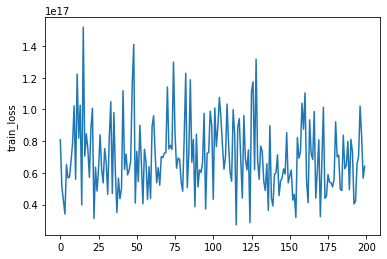

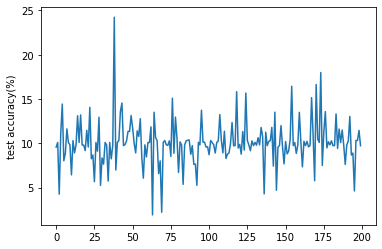

[ 9.58 10.1   4.26 11.12 14.43  8.03  8.85 11.63 10.08  9.82  6.44 10.31
  8.92  9.82 13.11 10.1  13.21  9.8   9.8   9.18 11.47  9.58 14.06  8.26
  8.68  5.67 10.09  9.11 12.95  5.26  8.35  7.65 10.1   9.81  5.74 10.1
  8.25  9.74 24.23  6.99 10.11 10.32 13.58 14.55  9.74  9.86 10.27 11.35
 11.35 13.14 11.72  9.99  8.92 11.41 10.78 12.78  8.38  6.07  9.83  8.46
 10.09 10.09 11.86  1.92 13.51 10.65 10.31  6.58  8.02  2.22 10.09 10.32
  9.83  9.77 10.28  8.52 15.09  8.87 12.96 10.54  6.71 10.16  9.82  5.37
  9.83 10.28 10.35 10.38  8.76  9.74  7.63  7.66  5.26 10.12  9.82 13.73
 10.13 10.13  9.58  9.61  8.71 10.32 10.09  9.84  8.91 10.1  10.26 13.24
 10.33  8.92 11.37  8.29  8.77  8.92  9.99 12.35  9.73  9.74 15.83  9.47
  9.88  8.78 11.33  9.23 15.67 10.32  9.8   9.17 10.28  9.74 10.11  9.79
 10.64  9.82 11.79 10.76  4.29 11.26  9.74 10.22 10.3  11.8   7.43 13.52
  4.7   9.56  9.76 12.    9.59  7.68 10.2   8.81  9.12 10.46 16.44  9.74
 10.09  8.86  9.82 13.5  10.1   7.34 10.23  9.74 10.

In [138]:
plt.plot(range(len(loss_train_FedAvg)), loss_train_FedAvg)
plt.ylabel('train_loss')
plt.show()
# plt.savefig('./save/fed_{}_{}_{}_C{}_iid{}.png'.format(args.dataset, args.model, args.epochs, args.frac, args.iid))

plt.plot(range(len(acc_test_FedAvg)), acc_test_FedAvg)
plt.ylabel('test accuracy(%)')
plt.show()
#print(loss_train_Fedavg)
# print(acc_test_FedAvg)
acc_test_FedAvg_ = np.array(acc_test_FedAvg)
loss_train_FedAvg_ = np.array(loss_train_FedAvg)
print(acc_test_FedAvg_)

pickle.dump(acc_test_FedAvg_, open('./results/FedAvg_Accuracy_N40_M13_A12', 'wb'), -1)
pickle.dump(loss_train_FedAvg_, open('./results/FedAvg_Loss_N40_M13_A12', 'wb'), -1)

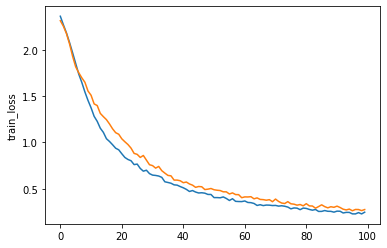

In [78]:
plt.plot(range(len(loss_train_Fedavg)), loss_train_Fedavg)
plt.plot(range(len(loss_train_Brea)), loss_train_Brea)
plt.ylabel('train_loss')
plt.show()